# Visualización numérica: Funciones de Jordan

Autor: Guillermo Andrés Arboleda
#### Tabla de contenido:
* [Importe de librerías](#import)
* [1. Generación de curvas de Jordan pseudoaleatorias](#pt1)
* [2. Animación de algunas funciones de Jordan](#pt2)
* [2.1 Transformaciones Lineales](#pt2.1)
* [2.2 Contracción del plano a la bola unitaria en $\mathbb{R}^{2}$](#pt2.2)



**Nota:** La sección 1, *Generación de curvas de Jordan pseudoaleatorias* fue prácticamente tomada de stackoverflow (ver referencias). Por otro lado, la sección 2 es nuestra implementación numérica en base a la documentación de la librería Manim de Python.


## Importe de librerías<a class="anchor" id="import"></a>

In [11]:
from manim import *
import ffmpeg
import math
import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt
from manim import X11

## 1. Generación de curvas de Jordan pseudoaleatorias <a class="anchor" id="pt1"></a>

En esta sección se utiliza la biblioteca Matplotlib en Python para generar y visualizar formas aleatorias compuestas por curvas de Bézier. Inicialmente se define una serie de puntos de control, se generan puntos aleatorios alrededor de estos, y luego se trazan las curvas de Bézier resultantes. Existe un bucle principal que itera sobre los diferentes conjuntos de puntos de control para crear varias formas, que en su gran mayoría serán curvas de Jordan. Por ultimo, se gráfica el resultado.

In [14]:
# fuente: https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib

bernstein = lambda n, k, t: np.math.comb(n, k) * t**k * (1. - t)**(n - k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.array([np.outer(bernstein(N - 1, i, t), points[i]) for i in range(N)]).sum(axis=0)
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1, self.p2 = p1, p2
        self.angle1, self.angle2 = angle1, angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2 - self.p1)**2))
        self.r = r * d
        self.p = np.array([self.p1, np.zeros(2), np.zeros(2), self.p2])
        self.calc_intermediate_points()

    def calc_intermediate_points(self):
        self.p[1] = self.p1 + self.r * np.array([np.cos(self.angle1), np.sin(self.angle1)])
        self.p[2] = self.p2 + self.r * np.array([np.cos(self.angle2 + np.pi), np.sin(self.angle2 + np.pi)])
        self.curve = bezier(self.p, self.numpoints)

def get_curve(points, **kw):
    segments = [Segment(points[i, :2], points[i + 1, :2], points[i, 2], points[i + 1, 2], **kw) for i in range(len(points) - 1)]
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p - np.mean(p, axis=0)
    s = np.arctan2(d[:, 0], d[:, 1])
    return p[np.argsort(s), :]

def get_bezier_curve(a, rad=0.2, edgy=0):
    p = np.arctan(edgy) / np.pi + 0.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0, :]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:, 1], d[:, 0])
    f = lambda ang: (ang >= 0) * ang + (ang < 0) * (ang + 2 * np.pi)
    ang = f(ang)
    ang1, ang2 = ang, np.roll(ang, 1)
    ang = p * ang1 + (1 - p) * ang2 + (np.abs(ang2 - ang1) > np.pi) * np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x, y = c.T
    return x, y, a

def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    mindst = mindst or 0.7 / n
    a = np.random.rand(n, 2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec >= 200:
        return a * scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec + 1)

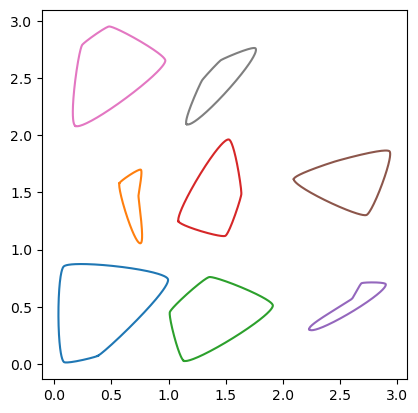

In [3]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

rad = 0.1
edgy = 0.005

for c in np.array([[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [0,2], [1,2]]):

    a = get_random_points(n=4, scale=1) + c
    cx,cy, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
    plt.plot(cx,cy)

plt.show()

## 2. Animación de algunas funciones de Jordan <a class="anchor" id="pt2"></a>

En esta sección del cuaderno se aplica la librería Manim de Python para visualizar mediante animaciones algunas funciones de Jordan. Se hace uso de las funciones definidas en la sección anterior para dibujar curvas de Jordan pseudoaleatorias y animar su transformación mediante cada función.

A continuación se crea la clase BaseTransformacion, que proporciona la estructura básica para realizar transformaciones y animaciones para las curvas generadas en la parte 1. 

In [5]:
# Constantes
EDGY = 0.005
RADIO_PUNTO = 0.05
ANCHO_CURVA = 0.02

class BaseTransformacion(Scene):
    def construct(self):
        self.camera.background_color = XKCD.PALEGREY

        # Crear planos cartesianos
        plano_origen = self.crear_plano_cartesiano()
        plano_imagen = self.crear_plano_cartesiano()  # Plano para la imagen

        # Ajustar los planos según sea necesario
        self.ajustar_plano_origen(plano_origen)
        self.ajustar_plano_imagen(plano_imagen)

        # Generar curvas originales en el plano de origen
        curvas_originales = self.generar_curvas_originales(plano_origen)

        # Graficar las curvas en ambos planos simultáneamente
        
        self.graficar_curvas(plano_imagen, curvas_originales, animated=False)  # Sin animación para el segundo plano
        self.graficar_curvas(plano_origen, curvas_originales)
        self.wait(2)

        # Aplicar la transformación al plano de origen
        self.aplicar_transformacion(plano_origen, curvas_originales)

        # Mostrar el plano imagen (sin animación)
        self.play(FadeIn(plano_imagen, run_time=0))

        self.wait(2)

    
    def crear_plano_cartesiano(self):
        """Crear un plano cartesiano."""
        return NumberPlane()
        
        
    def ajustar_plano_origen(self, plano):
        pass
    
    def ajustar_plano_imagen(self, plano):
        pass
    
    def generar_curvas_originales(self, plano):
        """Generar curvas originales con diferentes colores."""
        colores = [BLUE, ORANGE, GREEN, RED, YELLOW, PURPLE, PINK, TEAL, GREY]
        curvas_originales = []

        # Cuadrícula de puntos entre -8 y 8 en ambas componentes, separados por 2
        x_min, x_max, y_min, y_max, step = -4, 4, -2, 1, 2
        x_values = np.arange(x_min, x_max + step, step)
        y_values = np.arange(y_min, y_max + step, step)
        xx, yy = np.meshgrid(x_values, y_values)
        points_array = np.column_stack((xx.ravel(), yy.ravel()))

        for i, coords in enumerate(points_array):
            color = colores[i % len(colores)]  # Obtener el color de forma cíclica
            puntos_curva = self.generar_puntos_curva(coords, plano, color)
            curvas_originales.append(puntos_curva)

        return curvas_originales


    def generar_puntos_curva(self, coords, plano, color):
        """Generar puntos para una curva."""
        puntos = get_random_points(n=5, scale=1) + coords
        cx, cy, _ = get_bezier_curve(puntos, edgy=EDGY)
        return VGroup(*[Dot(plano.coords_to_point(x, y), color=color, radius=RADIO_PUNTO, stroke_width=ANCHO_CURVA) for x, y in zip(cx, cy)])

    def graficar_curvas(self, plano, curvas, animated=True):
        """Graficar las curvas en la escena."""
        grupo_objetos = VGroup(plano, *curvas)
        if animated:
            self.play(Create(grupo_objetos))
        else:
            self.add(grupo_objetos)
    def aplicar_transformacion(self, plano, curvas_originales):
        """Aplicar la transformación a ambas curvas y al plano."""
        transformaciones = [Transform(curva, curva.copy().apply_function(self.funcion_transformacion)) for curva in curvas_originales]
        transformaciones.append(Transform(plano, plano.copy().apply_function(self.funcion_transformacion)))
        self.play(AnimationGroup(*transformaciones, lag_ratio=0), run_time=2)

    def funcion_transformacion(self, punto):
        """Función de transformación."""
        pass

En las siguientes subsecciones se presenta la implementación de la clase BaseTransformacion para generar las animaciones de cada función de Jordan.

### 2.1 Transformaciones Lineales <a class="anchor" id="pt2.1"></a>
#### 2.1.1 Reflexiónes

In [6]:
def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.array([np.outer(bernstein(N - 1, i, t), points[i]) for i in range(N)]).sum(axis=0)
    return curve

class Reflexion(BaseTransformacion):
    def ajustar_plano_origen(self, plano):
        for line in plano.background_lines:
            line.set_stroke(color=BLUE, opacity=0.5, width=2)            
        plano.x_axis.set_color(BLACK)
        plano.y_axis.set_color(BLACK)
        
    def ajustar_plano_imagen(self, plano):
        for line in plano.background_lines:
            line.set_stroke(opacity=0)
        plano.x_axis.set_color(WHITE)
        plano.y_axis.set_color(WHITE)
        
    def funcion_transformacion(self, punto):
        x, y, z = punto
        return [x, -y, z]

# Ejecutar comando de Manim
%manim --disable_caching -ql -v WARNING -r 1920,1080 Reflexion


#### 2.1.2 Traslaciónes

In [7]:
def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.array([np.outer(bernstein(N - 1, i, t), points[i]) for i in range(N)]).sum(axis=0)
    return curve

class Traslacion(BaseTransformacion):
    def ajustar_plano(self, plano):
        plano.x_axis.set_color(BLACK)
        plano.y_axis.set_color(BLACK)    
    
    def ajustar_plano_imagen(self, plano):
        for line in plano.background_lines:
            line.set_stroke(color=RED, opacity=0.3, width=2)
            
        plano.x_axis.set_stroke(width=2)
        plano.y_axis.set_stroke(width=2)
        plano.x_axis.set_color(RED)
        plano.y_axis.set_color(RED)

    def funcion_transformacion(self, punto):
        x, y, z = punto
        return [x - 0.5, y - 1.5, z]
    
# Ejecutar comando de Manim
%manim --disable_caching -ql -v WARNING -r 1920,1080 Traslacion

#### 2.1.3 Rotaciónes

In [8]:
def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.array([np.outer(bernstein(N - 1, i, t), points[i]) for i in range(N)]).sum(axis=0)
    return curve

class Rotacion(BaseTransformacion):
    def ajustar_plano_origen(self, plano):
        for line in plano.background_lines:
            line.set_stroke(color=BLUE, opacity=0.5, width=2)            
        plano.x_axis.set_color(BLACK)
        plano.y_axis.set_color(BLACK)
        
    def ajustar_plano_imagen(self, plano):
        for line in plano.background_lines:
            line.set_stroke(opacity=0)
        plano.x_axis.set_color(WHITE)
        plano.y_axis.set_color(WHITE)
        
    def funcion_transformacion(self, punto):
        x, y, z = punto
        angulo=np.pi
        return [x * math.cos(angulo) - y * math.sin(angulo), x * math.sin(angulo) + y * math.cos(angulo), z]

# Ejecutar comando de Manim
%manim --disable_caching -ql -v WARNING -r 1920,1080 Rotacion

#### 2.1.4 Transformaciones lineales en general

In [16]:
def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.array([np.outer(bernstein(N - 1, i, t), points[i]) for i in range(N)]).sum(axis=0)
    return curve

class TransformacionLineal(BaseTransformacion): # Transformación lineal en general
    def ajustar_plano_origen(self, plano):
        for line in plano.background_lines:
            line.set_stroke(color=BLUE, opacity=0.5, width=2)            
        plano.x_axis.set_color(BLACK)
        plano.y_axis.set_color(BLACK)
        
    def ajustar_plano_imagen(self, plano):
        for line in plano.background_lines:
            line.set_stroke(opacity=0)
        plano.x_axis.set_color(WHITE)
        plano.y_axis.set_color(WHITE)
        
    def funcion_transformacion(self, punto):
        x, y, z = punto
        
        # coeficientes de la transformación:
        # angulo=np.pi
        a=-1
        b=0
        c=1
        d=-1
        e=0
        f=0
        
        return [a*x + b*y + e, c*x + d*y + f, z]

# Ejecutar comando de Manim
%manim --disable_caching -ql -v WARNING -r 1920,1080 TransformacionLineal

### 2.2 Contracción del plano a la bola unitaria en $\mathbb{R}^{2}$ <a class="anchor" id="pt2.2"></a>

In [17]:
def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.array([np.outer(bernstein(N - 1, i, t), points[i]) for i in range(N)]).sum(axis=0)
    return curve

class ProyeccionABolaUnitaria(BaseTransformacion):
    def ajustar_plano_origen(self, plano):
        for line in plano.background_lines:
            line.set_stroke(color=BLUE, opacity=0.5, width=2)            
        plano.x_axis.set_color(BLACK)
        plano.y_axis.set_color(BLACK)
        
    def ajustar_plano_imagen(self, plano):
        for line in plano.background_lines:
            line.set_stroke(opacity=0)
        plano.x_axis.set_color(WHITE)
        plano.y_axis.set_color(WHITE)
    
    def funcion_transformacion(self, punto):
        x, y, z = punto
        norma=np.sqrt((x**2) + (y**2))
        return [x/(1+norma), y/(1+norma), z] # f(x,y)=(x,y)/(1+√x^2+y^2) 


# Ejecutar comando de Manim
%manim --disable_caching -ql -v WARNING -r 1920,1080 ProyeccionABolaUnitaria

## Referencias

- Cox, M. (2013, junio 13). A primer on Bézier curves. Github.Io. https://pomax.github.io/bezierinfo/

- Create random shape/contour using matplotlib. (s/f). Stack Overflow. Recuperado de https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib

- Manim community edition. (s/f). Manim Community | Documentation. Recuperado de https://docs.manim.community/en/stable/